### x lines of Python
# Loading images


This notebook goes with a blog post: [_X Lines of Python: Loading images_](https://agilescientific.com/blog/2019/8/30/x-lines-of-python-loading-images)

In general, you can go one of two ways with images:

1. Load the image using a library that 'knows about' (i.e. uses language related to) images, like `PIL`, `pillow` (a port of `PIL`).
1. Load the image using a library that knows about arrays, like `matplotlib` or `scipy`.

In the first category, we'll take a look at the Python Imaging Library. The main points about this library:

- Reads and writes essentially any image format.
- Can do all sorts of manipulation (resizing, cropping, enhancing, drawing, compositing).
- Can convert to and from NumPy arrays.

In the second category, we'll look at reading and writing images with `matplotlib.image`, `scipy`, and `scikit-image`. All of these tools use `PIL` behind the scenes for some of their functionality. The main features of `matplotlib.image`:

- Only reads PNG format natively, i.e. without installing `PIL`.
- Doesn't do any image manipulation, although you can resize an image in `scipy`.
- Writes most common formats (PNG, JPG, GIF, plus PDF and SVG for vectors).
- Uses NumPy arrays implicitly.

----

This post uses data from [this tweet](https://twitter.com/seis_matters/status/1164271910634565632) by Prof Chris Jackson (Imperial College London). I don't know anything about the data. I doubt it has an open licence, but it's on Twitter, so...

----

We'll start with the usual prerequisites for our notebooks:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## PIL's `Image` object

To install `pillow`, do:

    conda install pillow
    
or

    pip install pillow
    
Note that you never actually import `pillow`. Instead, we import `PIL` as shown below.

[Here are the docs!](https://pillow.readthedocs.io/en/stable/)

In [2]:
from PIL import Image
im = Image.open("../data/EChTISYWkAA6_DV.jpeg")

In the notebook, the `repr` of this `Image` object is a convenient display of the image:

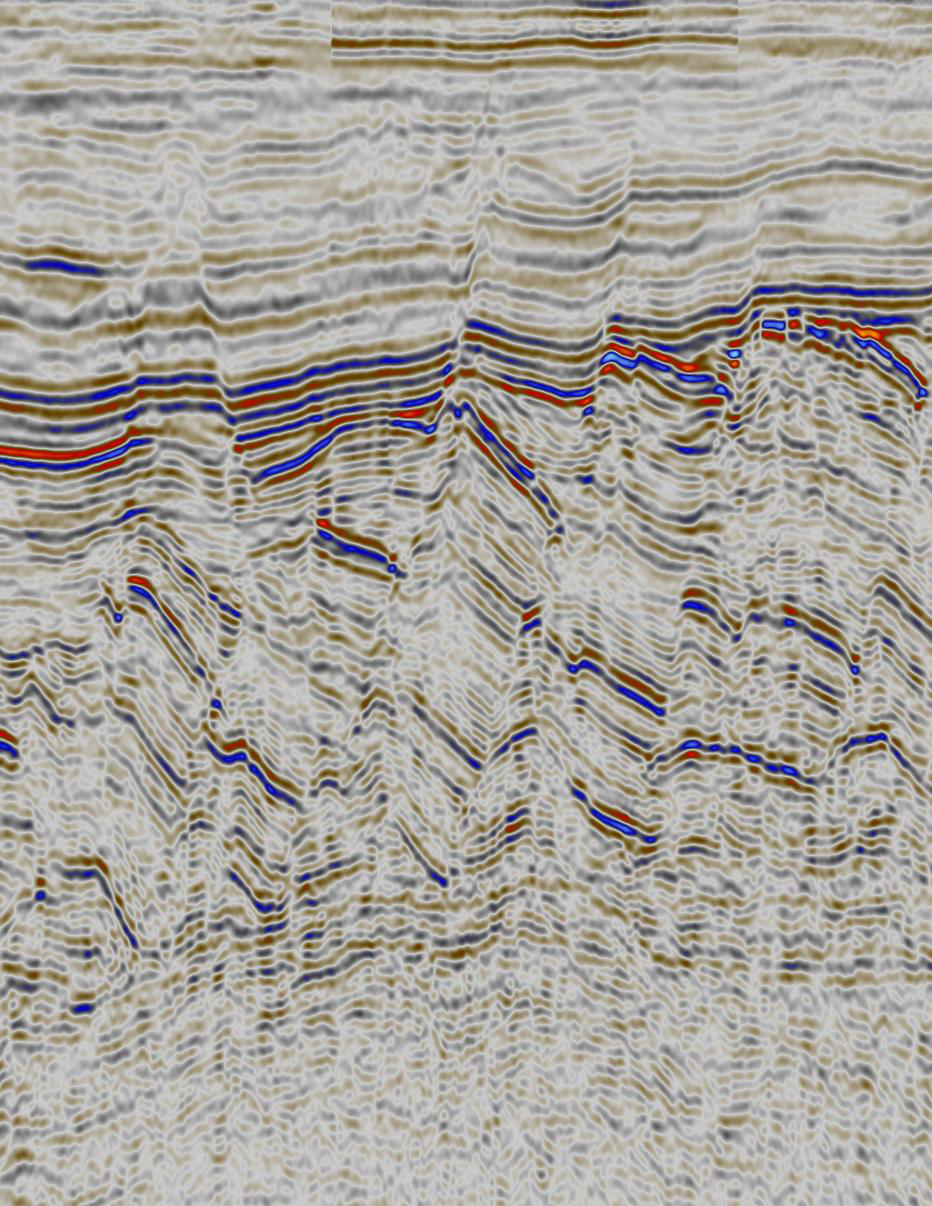

In [3]:
im

Notice that the size (not `shape`!) is reported as columns &times; rows, so it's different from a NumPy array, which is rows &times; cols.

In [4]:
im.size

(932, 1206)

In [5]:
np.array(im).shape

(1206, 932, 3)

(The 3rd dimension there is the channel: one each for red, green and blue.)

We can resize this image, but doing this while maintaining the aspect ratio is a bit fiddly becaue you have to compute the new dimensions yourself.

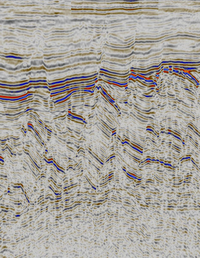

In [6]:
w, h = im.size

aspect = h / w

new_w = 200
new_h = int(new_w * aspect)   # Has to be an int.

im = im.resize((new_w, new_h), Image.ANTIALIAS)
im

You can save having to compute the new image size with the `thumbnail` method but be careful — it resizes the image in place. So I'l do it on a copy:

In [7]:
temp = im.copy()
temp.thumbnail((64, 64), Image.ANTIALIAS)

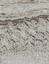

In [8]:
temp

We can plot this little image and see that it's now pixellated at any reasonable size:

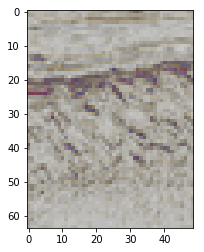

In [9]:
plt.imshow(temp, interpolation='none')

(Note in passing that we can pass an `Image` object to `imshow`. This is because it presents a NumPy-like interface. It's not an array though.)

We can ask `imshow` for some more sensible interpolation:

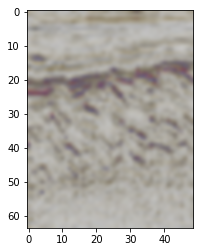

In [10]:
plt.imshow(temp, interpolation='bicubic')

## Handling images as arrays

As you see in the last example, we can treat PIL `Image` as an array sometimes, eg passing it to `imshow`. But sometimes it's convenient to treat images entirely as NumPy arrays. It's easy to convert between the two:

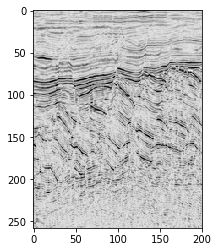

In [11]:
rgb = np.array(im)

red_channel = rgb[:, :, 0]
plt.imshow(red_channel, cmap='gray')

Note that NumPy doesn't implicitly care about the values:

In [12]:
np.max(red_channel)

230

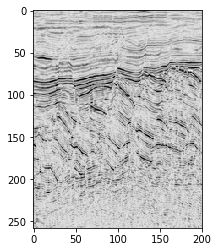

In [13]:
red_max1 = red_channel / 255
plt.imshow(red_max1, cmap='gray')

But if you convert back to a PIL `Image`, it cares. In fact, it won't even accept our decimal numbers in the 0–1 range:

In [14]:
im_red =  Image.fromarray(red_max1)
im_red

# This should throw an error.

OSError: cannot write mode F as PNG

<PIL.Image.Image image mode=F size=200x258 at 0x7F49CF6BC2B0>

We have to cast them to unsigned 8-bit integers (i.e. integers in the range 0 to 255):

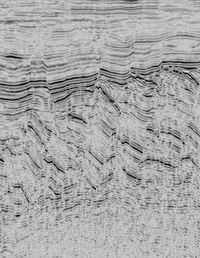

In [15]:
im_red = Image.fromarray(np.uint8(red_max1 * 255))
im_red

<div class="alert alert-success">
<h3>Exercise</h3>

<ul>
<li> Make a histogram of the image using [the `histogram()` method](http://effbot.org/imagingbook/image.htm#tag-Image.Image.histogram) on `Image`.</li> 
<li> Use the `crop()` method on the `Image` to crop the scalebar off the image.</li> 
<li> Crop the scalebar out of the image, and calculate the real-world size of each pixel in the image.</li> 
<li> Compute the luminance of the image $Y = 0.299 R + 0.587 G + 0.114 B$ and plot a transect across the middle of the image.</li> 
</ul>    

</div>

In [16]:
# Your code here...

## Loading an image from the web

With a little bit of trickery &mdash; using the `io.BytesIO` object, which allows us to make a file-like from a bunch of bytes &mdash; we can load an image from the web without saving a file:

In [17]:
import requests
from io import BytesIO

url = "https://pbs.twimg.com/media/EChTISYWkAA6_DV?format=jpg&name=large"
r = requests.get(url)
im = Image.open(BytesIO(r.content))

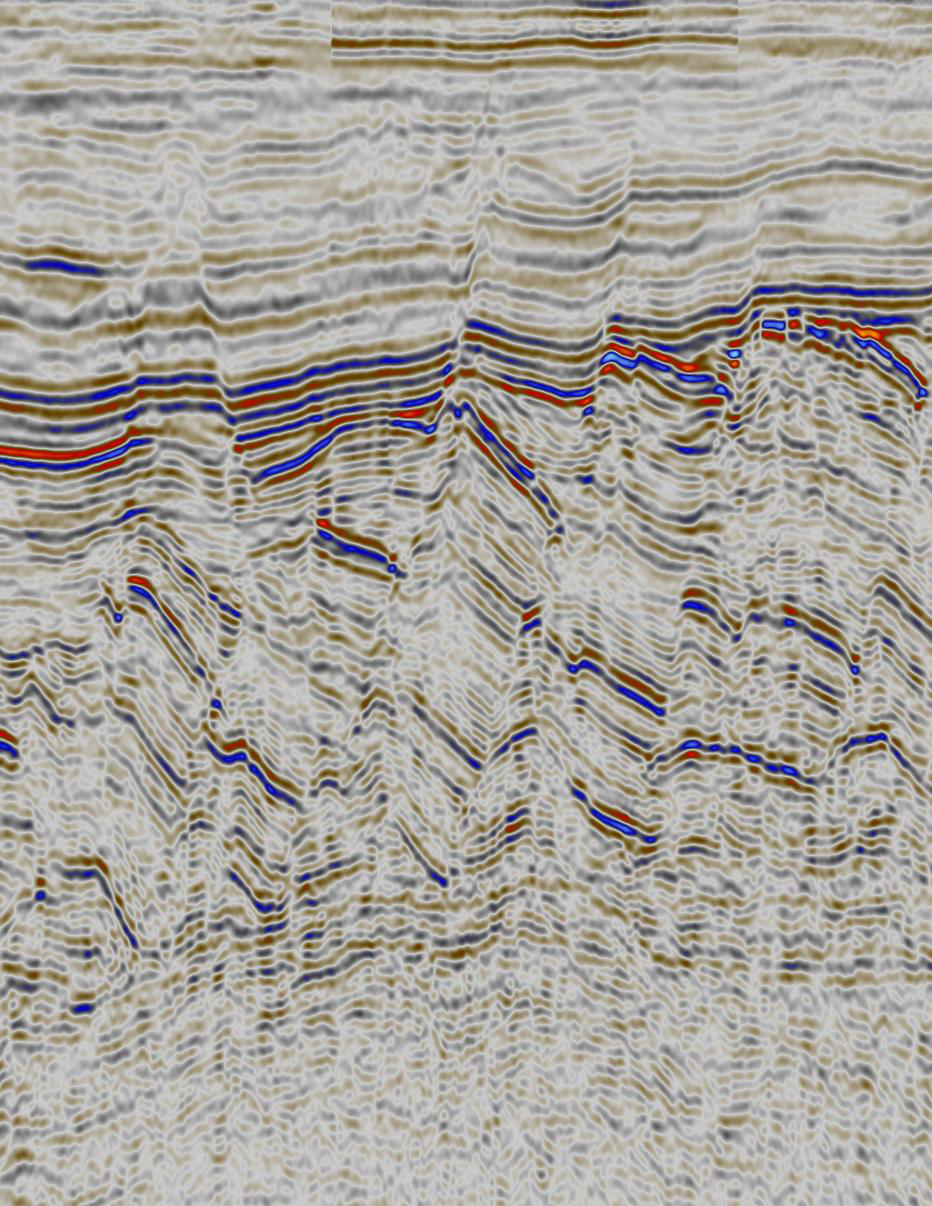

In [18]:
im

## A quick look at `matplotlib`

[Here are the docs.](https://matplotlib.org/users/image_tutorial.html)

`matplotlib` can only load PNGs natively (i.e. without having to install `PIL`). Unlike `PIL`, it loads them as single precision (32-bit) floats in the range [0, 1]. And, also unlike `PIL`, it is loaded as a NumPy array right off the bat.

In [19]:
import matplotlib.image as mpimage

img = mpimage.imread("../data/EChTISYWkAA6_DV.png")

In [20]:
type(img)

numpy.ndarray

In [21]:
img.dtype

dtype('float32')

A nice feature of `imread` is that it will accept a web URL as well as a filename:

In [22]:
img = mpimage.imread("https://pbs.twimg.com/media/EChTISYWkAA6_DV?format=png&name=large")
img.dtype

dtype('float32')

You can load a JPEG, but `matplotlib` will use `PIL` behind the scenes. `PIL` loads images as 8-bit unsigned integers in [0, 255], so that's what you'll end up with.

In [23]:
img = mpimage.imread("../data/EChTISYWkAA6_DV.jpeg")

In [24]:
img.dtype

dtype('uint8')

Notice we have an h &times; w &times; 3 array — this is an RGB image. PNGs often have a 4th channel, alpha or A, which holds opacity.

`plt.imshow()` plots 3-channel arrays like this in colour:

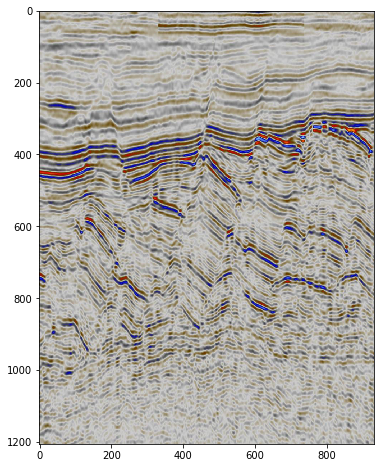

In [25]:
plt.figure(figsize=(6, 10))
plt.imshow(img)

We can plot only the red channel (say), and apply false colour via a lookup table:

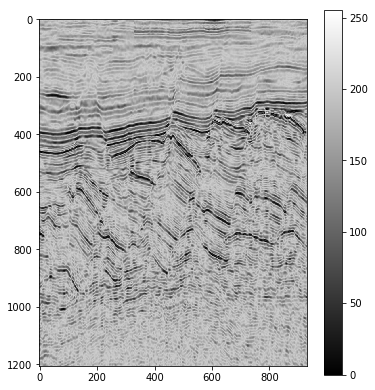

In [26]:
plt.figure(figsize=(6, 10))
plt.imshow(img[..., 0], cmap='gray')
plt.colorbar(shrink=0.67)

Let's look at the histogram for this channel:

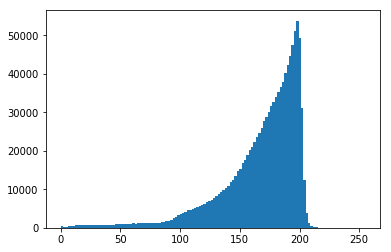

In [27]:
_ = plt.hist(img[..., 0].ravel(), bins=128)

## Reading images with `scipy`

Short version: since v 1.2, `scipy` no longer reads images. If you want a wrapper, use `matplotlib.image` or `imageio`.

## `skimage` is another option

I should mention that `scikit-image.io.imread()` can also read images, and accepts URLs. You can choose which backend library it uses to load things... I usually just use `PIL` directly when working with `skimage`.

In [5]:
import skimage

skimage.io.imread("https://pbs.twimg.com/media/EChTISYWkAA6_DV?format=png&name=large")

array([[[162, 158, 157],
        [163, 159, 158],
        [166, 162, 161],
        ...,
        [153, 151, 152],
        [148, 146, 147],
        [144, 142, 143]],

       [[166, 162, 161],
        [168, 164, 163],
        [171, 167, 166],
        ...,
        [152, 150, 151],
        [148, 146, 147],
        [145, 143, 144]],

       [[179, 175, 172],
        [180, 176, 173],
        [182, 178, 175],
        ...,
        [153, 153, 155],
        [150, 150, 152],
        [148, 148, 150]],

       ...,

       [[195, 190, 184],
        [194, 190, 181],
        [192, 188, 177],
        ...,
        [198, 198, 198],
        [196, 196, 196],
        [194, 194, 194]],

       [[198, 193, 187],
        [196, 192, 183],
        [193, 189, 178],
        ...,
        [197, 197, 197],
        [197, 197, 197],
        [198, 198, 198]],

       [[200, 195, 189],
        [197, 193, 184],
        [194, 190, 179],
        ...,
        [197, 197, 197],
        [200, 200, 200],
        [202, 202, 202]]

----

&copy; 2019 Agile Scientific, licensed CC-BY, please share this work.